In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

Gradient Boosting Regressor Model Performance:
RMSE: 3042.280056186381
Mean Absolute Error: 2040.9217316313552
R-squared (R²): 0.9647043021922223


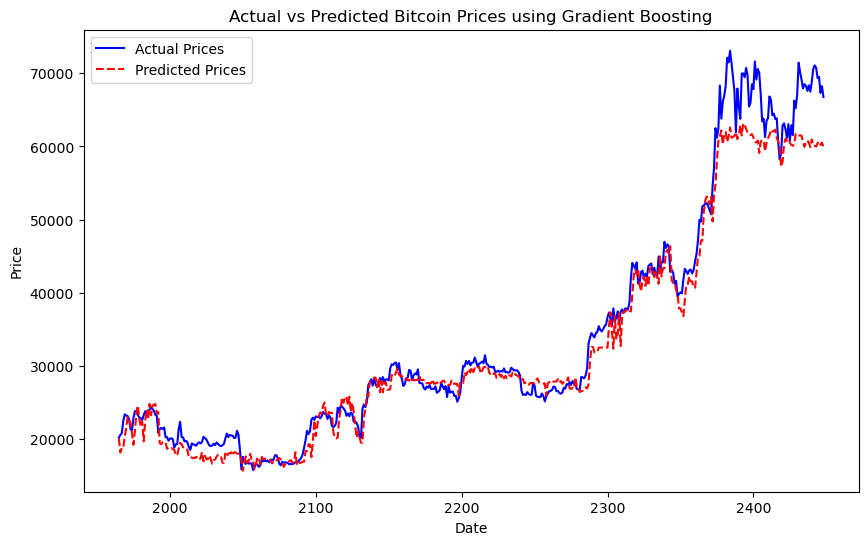

In [15]:
# Load the dataset
data = pd.read_csv('merged_data.csv')

features = ['Open', 'High', 'Low', 'Volume', 'DXY_Close', 'Gold_Close',
            'Crude_Oil_Price', 'SP500', 'Treasury_Yield']
target = 'Close'

# Scale the Features and Target
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])

# Convert the scaled data into a DataFrame
scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=features + [target])

# Prepare the Data for Gradient Boosting 
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i])
        targets.append(data[i, -1])
    return np.array(sequences), np.array(targets)

sequence_length = 30
X, y = create_sequences(scaled_data_df.values, sequence_length)

# Split the Data into Training and Testing Sets (80-20 split)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Gradient Boosting Regressor Model
gbr_model = GradientBoostingRegressor()

# Reshape X_train and X_test to be compatible with the model
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten the 3D array to 2D
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # Flatten the 3D array to 2D

# Fit the Model
gbr_model.fit(X_train_flat, y_train)

# Predict Using the Model
gbr_predictions = gbr_model.predict(X_test_flat)

# Reverse Scaling for Predictions 
y_test_unscaled = scaler.inverse_transform(
    np.hstack((np.zeros((y_test.shape[0], scaled_data_df.shape[1] - 1)), y_test.reshape(-1, 1)))
)
gbr_predictions_unscaled = scaler.inverse_transform(
    np.hstack((np.zeros((gbr_predictions.shape[0], scaled_data_df.shape[1] - 1)), gbr_predictions.reshape(-1, 1)))
)

# Evaluate the Gradient Boosting Regressor Model
rmse_gbr = np.sqrt(mean_squared_error(y_test_unscaled[:, -1], gbr_predictions_unscaled[:, -1]))
mae_gbr = mean_absolute_error(y_test_unscaled[:, -1], gbr_predictions_unscaled[:, -1])
r_squared_gbr = r2_score(y_test_unscaled[:, -1], gbr_predictions_unscaled[:, -1])

print("Gradient Boosting Regressor Model Performance:")
print(f'RMSE: {rmse_gbr}')
print(f"Mean Absolute Error: {mae_gbr}")
print(f"R-squared (R²): {r_squared_gbr}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(data.index[split_index + sequence_length:], y_test_unscaled[:, -1], label='Actual Prices', color='blue')
plt.plot(data.index[split_index + sequence_length:], gbr_predictions_unscaled[:, -1], label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Bitcoin Prices using Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

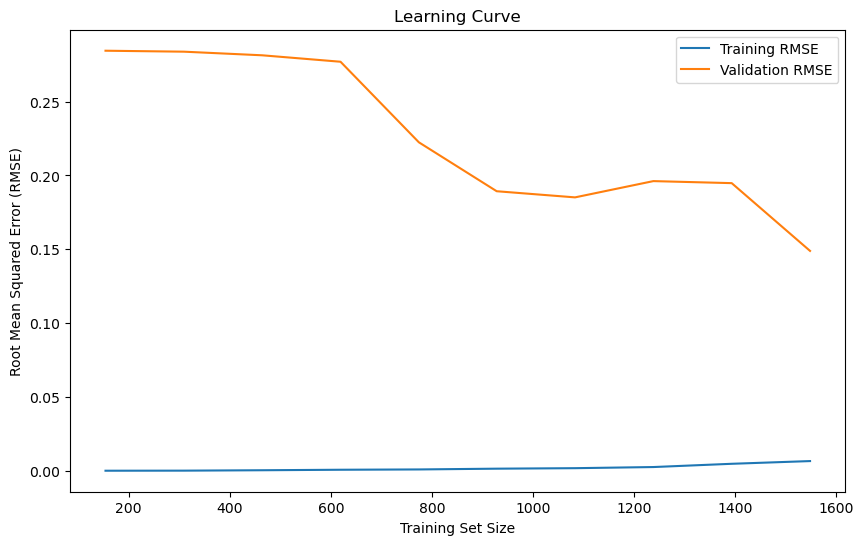

In [21]:
train_sizes, train_scores, test_scores = learning_curve(
    gbr_model, X_train_flat, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.sqrt(train_scores_mean), label='Training RMSE')
plt.plot(train_sizes, np.sqrt(test_scores_mean), label='Validation RMSE')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.show()

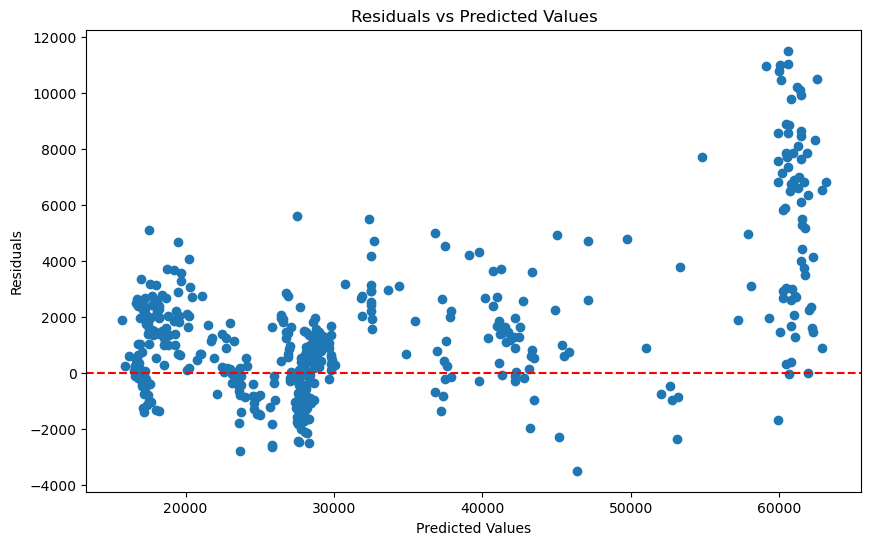

In [19]:
residuals = y_test_unscaled[:, -1] - gbr_predictions_unscaled[:, -1]

plt.figure(figsize=(10, 6))
plt.scatter(gbr_predictions_unscaled[:, -1], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()